# Gold Price Historical Data

- Gold, the yellow shiny metal, has been the fancy of mankind since ages. From making jewelry to being used as an investment, gold covers a huge spectrum of use cases.
- Daily gold price historical data in USD.

Bellow there's a summary with the description of each variable of the dataset:

| Variable | Description|
|:------:|:------:|
| Date | Date traded |
| Value | Gold price in USD currency|

For more information, use the [link](https://www.kaggle.com/datasets/arashnic/learn-time-series-forecasting-from-gold-price?resource=download) that redirects to the Kaggle's Page.


## Objectives

Create 3 different models to predict the next silver prices.
Models:
- ARIMA
- Simple RNN
- LSTM

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

## Data Cleaning and Feature Engineering

In [2]:
data = pd.read_csv('data/gold_price_data.csv')
data.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10787 non-null  object 
 1   Value   10787 non-null  float64
dtypes: float64(1), object(1)
memory usage: 168.7+ KB


As shown above, there are 13736 entries separated between 4 columns and there are no null values in the entire dataset. There are 1 column with "object" dtype and 3 columns with dtype "float64".

In [133]:
len(data.Date.unique())

10787

There are 13736 unique daily values, so, there is one entry for each day with no duplicates.

In [134]:
data.describe()

,Value
count,10787.000000
mean,653.596634
std,434.030848
min,35.100000
25%,349.200000
50%,409.350000
75%,1061.625000
max,1895.000000


There is a difference between count values for "USD", "GBP" and "EURO". Therefore, "GBP" will be used for the time series analysis since is the variable with more values.

It is convenient when working with time series to transform the "Date" column into a "datetime" dtype and set it as the index.

In [135]:
data['Date'] =  pd.to_datetime(data.Date)
data.set_index('Date', inplace=True)

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10787 entries, 1970-01-01 to 2020-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   10787 non-null  float64
dtypes: float64(1)
memory usage: 168.5 KB


In [137]:
data_ts = data['1979':]

In [138]:
data_ts

,Value
Date,
1979-01-01,226.00
1979-01-02,226.80
1979-01-03,218.60
1979-01-04,223.15
1979-01-05,225.50
...,...
2020-03-09,1672.50
2020-03-10,1655.70
2020-03-11,1653.75


In [139]:
data_bus = data_ts.resample('B').sum()
data_bus

,Value
Date,
1979-01-01,226.00
1979-01-02,226.80
1979-01-03,218.60
1979-01-04,223.15
1979-01-05,225.50
...,...
2020-03-09,1672.50
2020-03-10,1655.70
2020-03-11,1653.75


As shown above, the transformation was successful and the time series analysis can begin.

<AxesSubplot:xlabel='Date'>

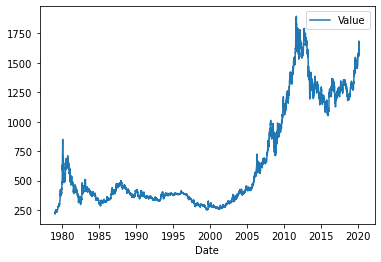

In [140]:
sns.lineplot(data=data_bus)

The time series doesn't behave as a stationary series since it has a large autocorrelation between values and does not have a constant mean and a constant variant. There are 3 distinct high values periods in 1980, 2010, and 2020.

<AxesSubplot:ylabel='Count'>

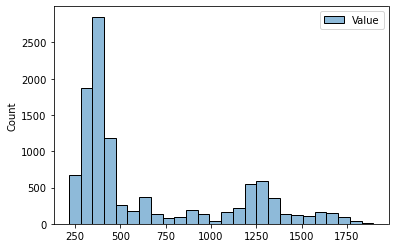

In [141]:
sns.histplot(data_bus)

The histplot shows that the distribution has a right skew, assuring that the distribution is not normal.

In [142]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data_bus)
print(f'ADF = {adf}')
print(f'p-value value = {pvalue}')

ADF = -0.019659952928539507
p-value value = 0.956875707134756


As expected, the time series doesn't passed in the ADF Test. Therefore, I will perform a differentiation to minimize trend effects and autocorrelation.

In [143]:
diff_data = data_bus.diff()

<AxesSubplot:xlabel='Date'>

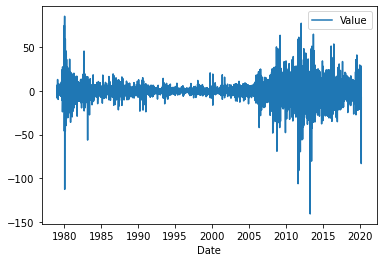

In [144]:
sns.lineplot(data=diff_data)

<AxesSubplot:ylabel='Count'>

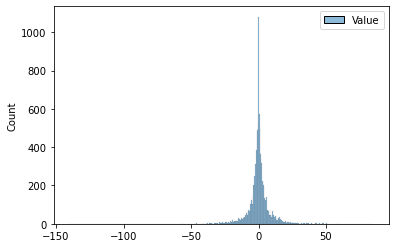

In [145]:
sns.histplot(diff_data)

Now the variations seems to occuor in a much smaller scale and the histogram seems to have a behavior closer to a normal distribution.

In [146]:
diff_data = data.diff()

In [147]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(diff_data[1:])
print(f'ADF = {adf}')
print(f'p-value = {pvalue}')

ADF = -17.568807521617387
p-value = 4.061374360446884e-30


As expected, the p-value was much smaller, showing that one differentiation is enough to make our series stationary.

In [148]:
def plots(data, lags=None):
    fig = plt.subplots(figsize=(12,4))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

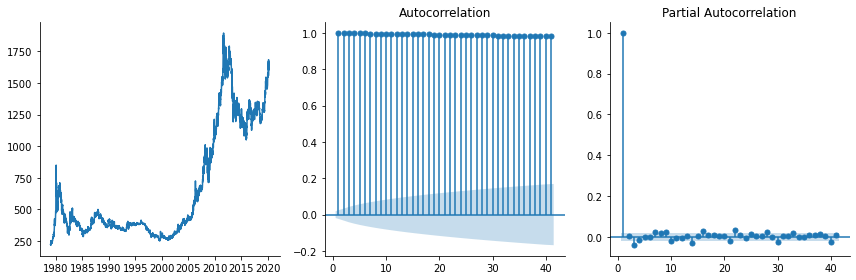

In [149]:
plots(data_bus)

The PACF plot has a significant spike at lag 1 and decay largely to lag 2, that stills have a significant value. 

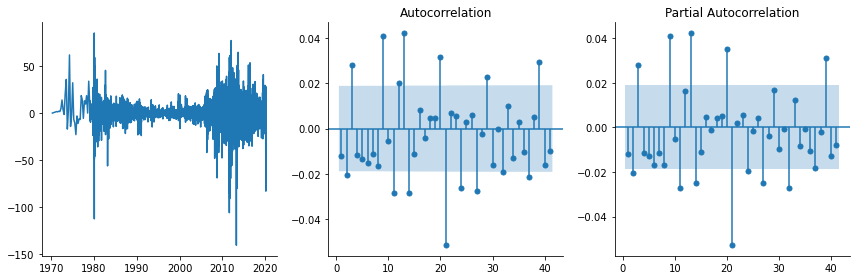

In [150]:
plots(diff_data[1:])

The differentiated data shows a different pattern, with a negative autocorrelation for the first 2 values and a positive one for the third. Since it's not very clear how to determinate p and q by those graphs, I will use a grid search to find the best ARIMA parameters.

In [151]:
ss_decomposition = seasonal_decompose(x=data_bus, model='additive', period=6)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

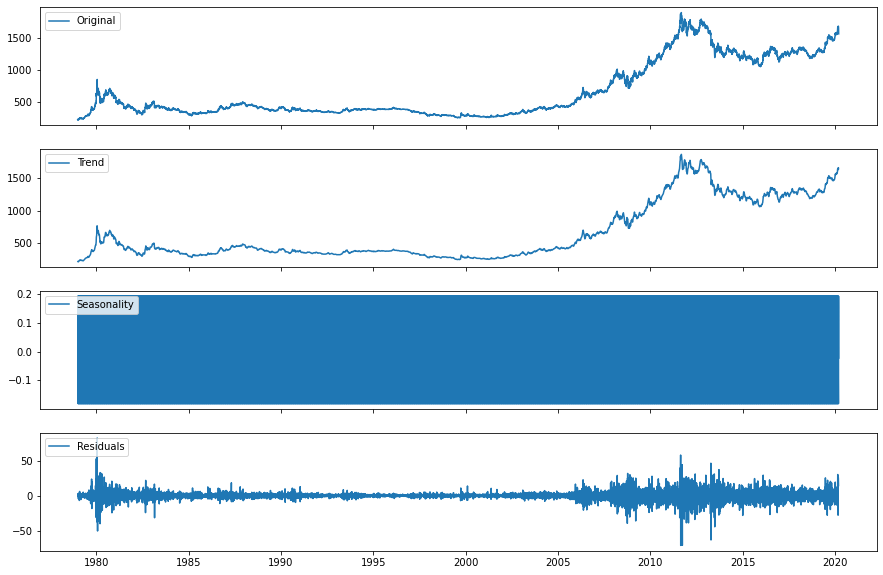

In [152]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(data_bus, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

The time series decomposition shows the absence of seasonality, which is expected since stock prices do not usually vary seasonally.

## Summary for Data Cleaning and Feature Engineering

- Time Series transformed to DateTime (business) and set as index;
- Series didn't pass the ADF Test (non-stationary);
- One differentiation was enough to make it stationary;
- Standard Scaler must be used to use Neural Networks.

## Model Creation

### ARIMA

In [153]:
# Train and test split
split_size = int(len(data_bus)*0.98)

train_df = data_bus[:split_size]
test_df = data_bus[split_size:]

In [154]:
stepwise_model = auto_arima(train_df, start_p=0, start_q=0, start_d=0,
                            max_p=4, max_q=4, max_d=1,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75896.969, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75896.136, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=75896.013, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75896.310, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=75896.568, Time=3.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=75893.593, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=75890.327, Time=5.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=75856.865, Time=14.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=75894.061, Time=4.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=75894.118, Time=8.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=75892.211, Time=8.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=75892.232, Time=8.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=75894.319, Time=9.34 sec
 ARIMA(2,1,2)(0,0,0)[0] 

In [155]:
arima = sm.tsa.statespace.SARIMAX(train_df, order=(2,1,2)).fit()

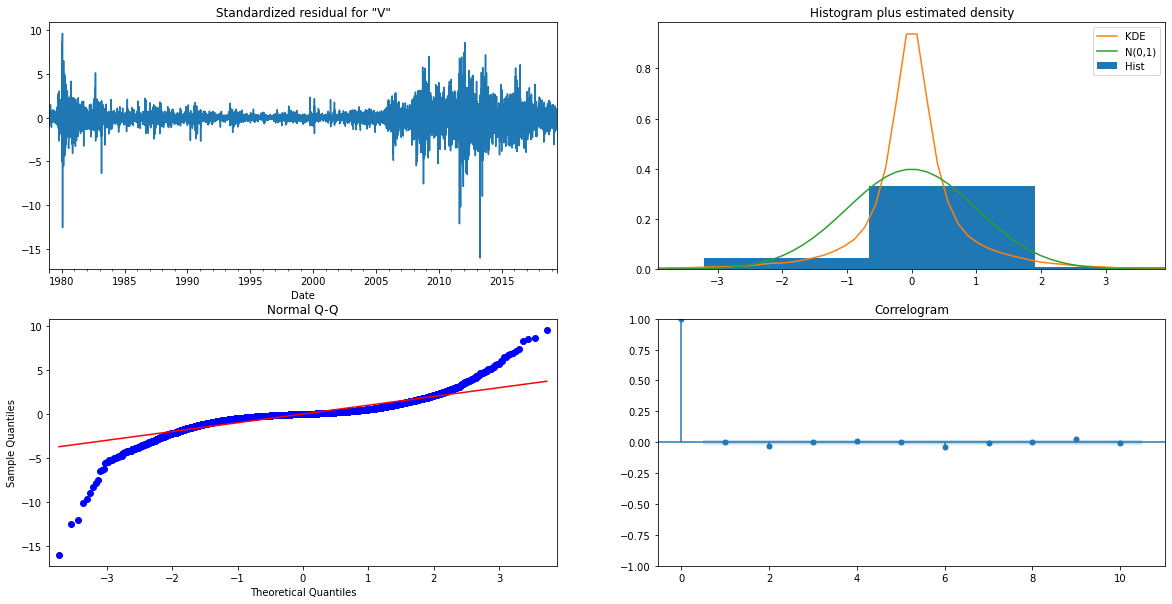

In [156]:
arima.plot_diagnostics(figsize = (20,10));

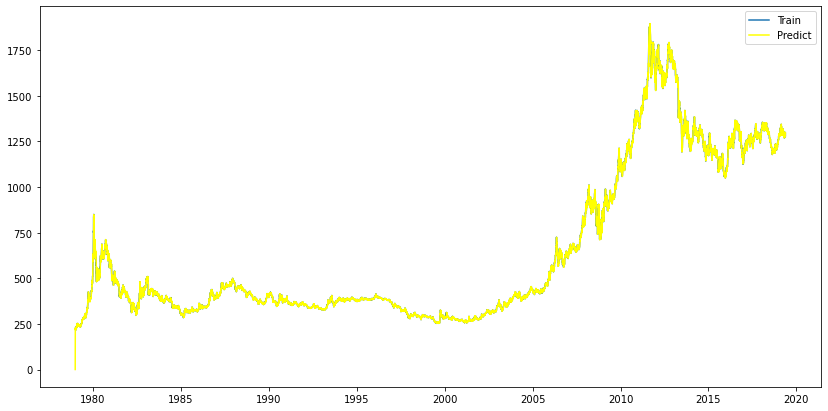

In [157]:
# Real Data vs Predictions
train = train_df
predictions = arima.fittedvalues

# Plot
plt.figure(figsize=(14, 7))
plt.plot(train, label = 'Train') 
plt.plot(predictions, color = 'yellow', label = 'Predict') 
plt.legend(loc = 'best') 
plt.show()

In [158]:
forecast_arima = arima.forecast(len(test_df), alpha = 0.05) 
forecast_arima

2019-05-20    1280.728035
2019-05-21    1280.184411
2019-05-22    1280.574553
2019-05-23    1280.861283
2019-05-24    1280.320211
                 ...     
2020-03-09    1280.543341
2020-03-10    1280.541111
2020-03-11    1280.539352
2020-03-12    1280.542515
2020-03-13    1280.542318
Freq: B, Name: predicted_mean, Length: 215, dtype: float64

In [159]:
def plot_model_predictions(test, forecast, model):
    
    plt.figure(figsize=(14, 7))
    plt.plot(train_df['2012':], label = 'Train Data')
    plt.plot(test, label = 'Test Data')
    plt.plot(forecast, label = 'Predictions')
    plt.title(f'{model} Predictions')
    plt.legend(loc = 'upper left', fontsize = 12)
    plt.show()

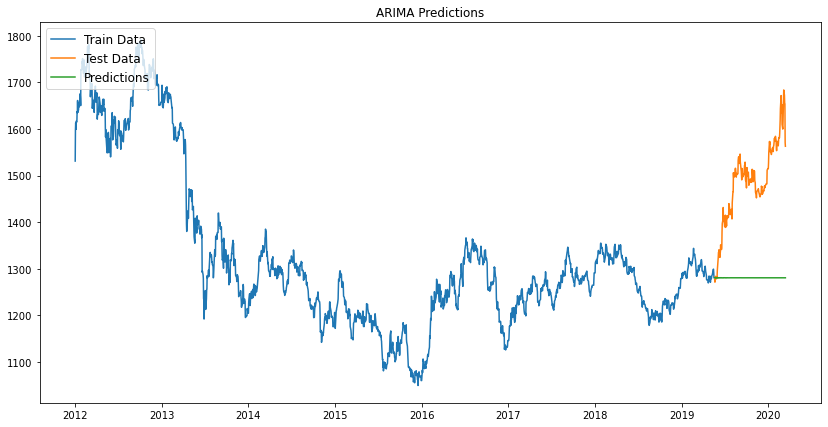

In [160]:
plot_model_predictions(test_df['Value'], forecast_arima, 'ARIMA')

In [161]:
arima_mse = mean_squared_error(test_df, forecast_arima)
arima_mse

48830.73365451037

### Simple RNN

In [162]:
# Scaling data
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

In [163]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [164]:
generator

In [187]:
def fit_rnn_model(model, n_cells, n_epochs):
    
    #callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    model.add(SimpleRNN(n_cells, input_shape=(n_input, 1)))#, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    model.fit(generator, epochs=n_epochs)#, callbacks=[callback])

In [179]:
def predictions(test, model):
    
    test_predictions = list()
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(test)):
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred) 
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
    true_predictions = scaler.inverse_transform(test_predictions)
    test['Predictions'] = scaler.inverse_transform(test_predictions)
        
    return test

In [203]:
rnn_simple = Sequential()
fit_model(rnn_simple, 10, 10)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
10532/10532 [==============================] - 13s 1ms/step - loss: 0.0114
Epoch 2/10
10532/10532 [==============================] - 15s 1ms/step - loss: 8.1531e-04
Epoch 3/10
10532/10532 [==============================] - 15s 1ms/step - loss: 7.5126e-04
Epoch 4/10
10532/10532 [==============================] - 14s 1ms/step - loss: 7.2407e-04
Epoch 5/10
10532/10532 [==============================] - 15s 1ms/step - loss: 7.0189e-04
Epoch 

In [204]:
def plot_loss(model):
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

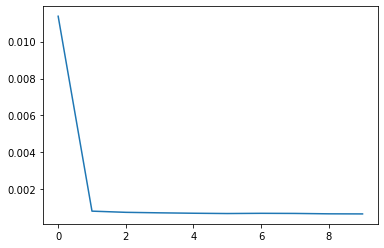

In [205]:
plot_loss(rnn_simple)

In [206]:
predictions(test_df, rnn_simple)

,Value,Predictions
Date,,
2019-05-20,1276.85,1281.744507
2019-05-21,1271.15,1285.176025
2019-05-22,1273.80,1289.080566
2019-05-23,1283.65,1293.037354
2019-05-24,1282.50,1296.957031
...,...,...
2020-03-09,1672.50,1624.439453
2020-03-10,1655.70,1624.673828
2020-03-11,1653.75,1624.902588


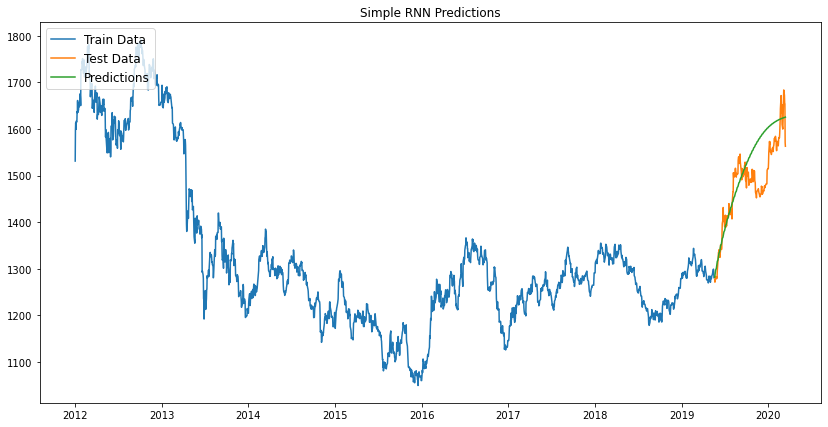

In [207]:
plot_model_predictions(test_df['Value'], test_df['Predictions'], 'Simple RNN')

In [208]:
rnn_simple.save('rnn_model')

INFO:tensorflow:Assets written to: rnn_model\assets


In [209]:
rnn_mse = mean_squared_error(test_df['Value'], test_df['Predictions'])
rnn_mse

3569.968403087139

### LSTM

In [353]:
def fit_lstm_model(model, n_cells, n_epochs):
    
    callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    model.add(LSTM(n_cells, input_shape=(n_input, 1)))#, activation='relu')
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    model.fit(generator, epochs=n_epochs, callbacks=[callback])

In [451]:
keras.backend.clear_session()

In [472]:
lstm = Sequential()
fit_model(lstm, 10, 2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
10532/10532 [==============================] - 13s 1ms/step - loss: 0.0024
Epoch 2/2
10532/10532 [==============================] - 13s 1ms/step - loss: 7.4945e-04


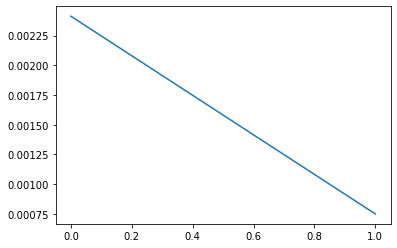

In [473]:
plot_loss(lstm)

In [474]:
predictions(test_df, lstm)

,Value,Predictions
Date,,
2019-05-20,1276.85,1287.528809
2019-05-21,1271.15,1297.087036
2019-05-22,1273.80,1307.090576
2019-05-23,1283.65,1317.080688
2019-05-24,1282.50,1326.971680
...,...,...
2020-03-09,1672.50,1574.058960
2020-03-10,1655.70,1574.058960
2020-03-11,1653.75,1574.058960


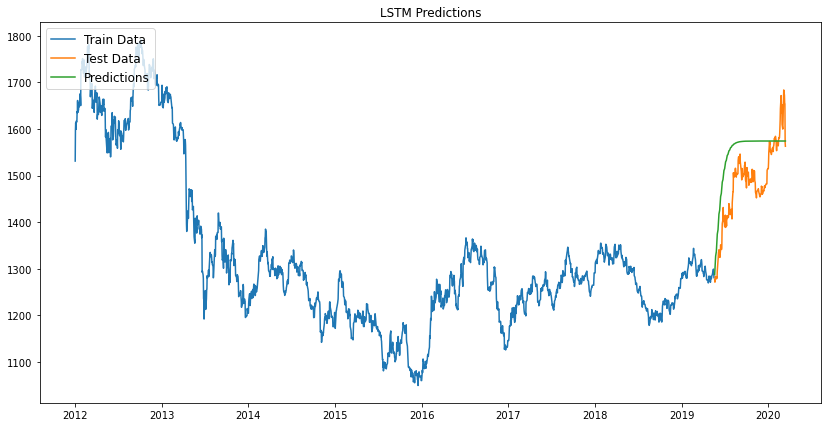

In [475]:
plot_model_predictions(test_df['Value'], test_df['Predictions'], 'LSTM')

In [476]:
lstm_mse = mean_squared_error(test_df['Value'], test_df['Predictions'])
lstm_mse

7026.592495476416

In [489]:
dict = {
    'Models': ['ARIMA', 'RNN', 'LSTM'],
    'MSE': [arima_mse, rnn_mse, lstm_mse]
}

pd.DataFrame(dict).set_index('Models')

,MSE
Models,
ARIMA,48830.733655
RNN,3569.968403
LSTM,7026.592495


Therefore, the RNN Model was the best choosed to forecast since it has the smaller error comparing to the other models.

## Conclusion

Actions taken in Data Cleaning and Feature Engineering:
- Time Series transformed to DateTime (business) and set as index;
- Series didn't pass the ADF Test (non-stationary);
- One differentiation was enough to make it stationary;
- Standard Scaler must be used to use Neural Networks.
    
Model Creation Results:
- The best ARIMA model had ARIMA(2,1,2) configuration;
- RNN achieved a better result then ARIMA and LSTM.

## Next Steps

For the upcoming works, I suggest trying different neural network configurations in order to obtain a better result.